In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# Plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
# nlp libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer 

from sklearn.svm import LinearSVC

In [2]:
train_df= pd.read_csv('../IndependenceDayHackathon/train_tGmol3O/train.csv')
test_eval= pd.read_csv('../IndependenceDayHackathon/test_8iecVfC/test.csv')

In [3]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [4]:
# Converting binary column to category
#binary_col = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
# counts = []
# for category in categories:
#     counts.append((category, train_df[category].sum()))
# df_stats = pd.DataFrame(counts, columns=['topic', 'count'])
# df_stats

binary_col= list(train_df.columns.values)[3:]

In [5]:
binary_col

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

In [6]:
col_sums= train_df.iloc[:,3:].sum()

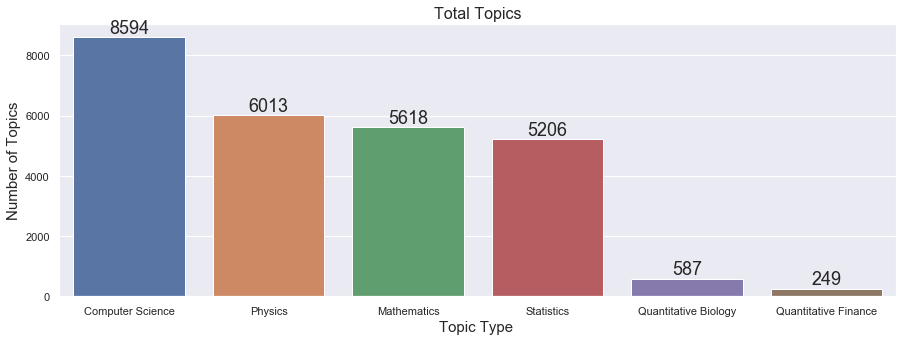

In [7]:
sns.set(font_scale = 1)
plt.figure(figsize=(15,5))

ax= sns.barplot(binary_col, col_sums)

plt.title("Total Topics", fontsize=16)
plt.ylabel('Number of Topics', fontsize=15)
plt.xlabel('Topic Type ', fontsize=15)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

In [8]:
rowSums = train_df.iloc[:,3:].sum(axis=1)
multiLabel_topics = rowSums.value_counts()

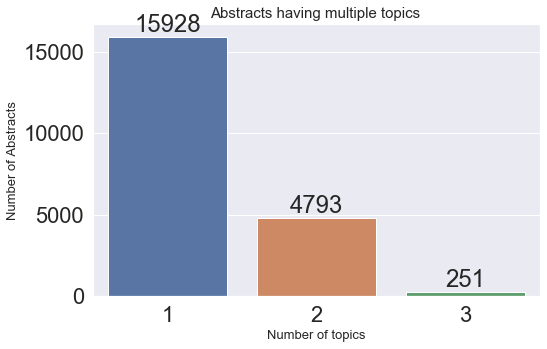

In [9]:
sns.set(font_scale = 2)
plt.figure(figsize=(8,5))

ax = sns.barplot(multiLabel_topics.index, multiLabel_topics.values)

plt.title("Abstracts having multiple topics ",fontsize=15)
plt.ylabel('Number of Abstracts', fontsize=13)
plt.xlabel('Number of topics', fontsize=13)

#adding the text labels
rects = ax.patches
labels = multiLabel_topics.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [10]:
# data cleaning
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [11]:
# Apply on train data
train_df['ABSTRACT'] = train_df['ABSTRACT'].str.lower()
train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(cleanHtml)
train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(cleanPunc)
train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(keepAlpha)

In [12]:
# Apply on final data
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].str.lower()
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].apply(cleanHtml)
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].apply(cleanPunc)
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].apply(keepAlpha)

In [13]:
# Removing Stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(removeStopWords)

In [14]:
# Stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

train_df['ABSTRACT'] = train_df['ABSTRACT'].apply(stemming)

In [15]:
# Apply above functions of final data too
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].apply(removeStopWords)
test_eval['ABSTRACT'] = test_eval['ABSTRACT'].apply(stemming)

In [16]:
# Train-Test Split

from sklearn.model_selection import train_test_split

train, test = train_test_split(train_df, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(14680, 9)
(6292, 9)


In [17]:
train_text = train['ABSTRACT']
test_text = test['ABSTRACT']

In [18]:
# TF- IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
# vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [19]:
# train test split
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['ID','ABSTRACT','TITLE'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['ID','ABSTRACT','TITLE'], axis=1)

In [20]:
test_vector= vectorizer.transform(test_eval['ABSTRACT'])

In [21]:
# Multi- Label classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [22]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in binary_col:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")
    
     # calculating test accuracy
    test_eval[category]= LogReg_pipeline.predict(test_vector)


**Processing Computer Science comments...**
Test accuracy is 0.8558486967577876


**Processing Physics comments...**
Test accuracy is 0.9237126509853782


**Processing Mathematics comments...**
Test accuracy is 0.8930387794024157


**Processing Statistics comments...**
Test accuracy is 0.8793706293706294


**Processing Quantitative Biology comments...**
Test accuracy is 0.9693261284170375


**Processing Quantitative Finance comments...**
Test accuracy is 0.9896694214876033


Wall time: 17.3 s


In [48]:
# Linear SVC model
#%%time

# Using pipeline for applying linear SVC and one vs rest classifier

SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(loss= 'hinge', C= 5.5,max_iter=1000), n_jobs=-1)),
            ])

for category in binary_col:
    print('**Processing {} comments...**'.format(category))
    
    # Training Linear SVC model on train data
    SVC_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = SVC_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")
    
     # calculating test accuracy
    test_eval[category]= SVC_pipeline.predict(test_vector)

**Processing Computer Science comments...**
Test accuracy is 0.8658614113159567


**Processing Physics comments...**
Test accuracy is 0.9302288620470439


**Processing Mathematics comments...**
Test accuracy is 0.9028925619834711


**Processing Statistics comments...**
Test accuracy is 0.8842975206611571


**Processing Quantitative Biology comments...**
Test accuracy is 0.9726636999364272


**Processing Quantitative Finance comments...**
Test accuracy is 0.9936427209154481




In [49]:
final_df= test_eval.drop(labels =['TITLE','ABSTRACT'],axis=1)
final_df.to_csv('.../IndependenceDayHackathon/Output6.csv')